In [476]:
from sklearn.linear_model import LogisticRegression# Import Python libaries
%matplotlib inline

# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import linear_model
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)

# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from numpy import cov
from scipy.stats import pearsonr
import pydot
from sklearn.model_selection import LeaveOneOut
from sklearn.naive_bayes import GaussianNB
# from sklearn.externals import joblib

# Miscellaneous
import os
import io

In [463]:
dropped = ['Atmosphere', 'Mass', 'Init_R', 'Fin_R', 'Voltage', 'Res_Volt', 'PulseTime_I', 'I_Mean']
def import_file(filename):
    # Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'Charge_Tot', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    
    
    
    # Drop problematic data for this particular analysis
    dropped_features = ['Atmosphere', 'Res_Drop',
             'PulseTime_I', 'I_Mean', 'Maxima']
    df = df.drop(dropped_features, axis=1)
    
    
    
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    df = df.drop('Map File ID', axis = 1)
    df = df.drop('Tube Diam', axis = 1)
    categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def import_file_noOneHot(filename):
# Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    # Drop problematic data for this particular analysis
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    df = df.drop('Map File ID', axis = 1)
    df = df.drop('Tube Diam', axis = 1)
    # categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    # df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def categorize_yield(df):
    yield_cat = []
    threshold = 50
    for i in range(0, len(df)):
        if df['Graphene_Yield'].iloc[i] < threshold:
            yield_cat.append(0)
        # elif df['Graphene_Yield'].iloc[i] > 50 and df['TwoDtoG'].iloc[i] < 0.8:
        else:
            yield_cat.append(1)
    print(len(df))
    print(len(yield_cat))
    df['Yield_Cat'] = yield_cat
    
def leave_one_out_proc(clf):
    # Leave one out evaluation
    # enumerate splits
    y_true, y_pred = list(), list()
    # Create leave one out procedure
    cv = LeaveOneOut()
    for train_ix, test_ix in cv.split(features):
        # split data
        train_features, test_features = features[train_ix, :], features[test_ix, :]
        train_labels, test_labels = labels[train_ix], labels[test_ix]
        clf.fit(train_features, train_labels)
        # evaluate model
        yhat = clf.predict(test_features)
        # store
        y_true.append(test_labels[0])
        y_pred.append(yhat[0])
    print('doneskies')
    return y_true, y_pred, clf

def category_normalization_theonesyoualwaysuse(df):
    groups = df.groupby(['Material'])
    norm_I_Max = []
    norm_charge_tot=[]
    for name, group in groups:
        I_Max_array = np.asfarray(group.I_Max)
        charge_tot_array = np.asfarray(group.Charge_Tot)
        mean_I_Max = np.mean(I_Max_array)
        mean_charge_tot = np.mean(charge_tot_array)
        std_I_Max = np.std(I_Max_array)
        std_charge_tot = np.std(charge_tot_array)
        print("Mean of ", name, "is ", mean_I_Max)
        norm_I_Max_cat = np.divide(np.subtract(I_Max_array, mean_I_Max), std_I_Max)
        norm_charge_tot_cat = np.divide(np.subtract(charge_tot_array, mean_charge_tot), std_charge_tot)
        norm_I_Max = np.append(norm_I_Max, norm_I_Max_cat)
        norm_charge_tot = np.append(norm_charge_tot, norm_charge_tot_cat)
    return norm_I_Max, norm_charge_tot

def category_normalization_mass(df):
    groups = df.groupby(['Material'])
    norm_array = []
    for name, group in groups:
        yield_array = np.asfarray(group.Mass)
        mean_yield = np.mean(yield_array)
        std_yield = np.std(yield_array)
        print("Mean of ", name, "is ", mean_yield)
        norm_yield_cat = np.divide(np.subtract(yield_array, mean_yield), std_yield)
        norm_array = np.append(norm_array, norm_yield_cat)
    return norm_array

In [472]:
# Import file
filename='FJH_ML_All_7_Edited.csv'
df1 = import_file_noOneHot(filename)
Imax, chargetot = category_normalization_theonesyoualwaysuse(df1)
yield_array = category_normalization_mass(df1)
df = import_file(filename)
# df['Norm_I_Max'] = Imax
df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
# df['Discharge_Rate'] = (df['Volt_Drop']/df['Mass'])/df['PulseTime']
# df['norm_mass'] = yield_array
# df['cap_energy'] = 0.5*df['Voltage']*df['Voltage']*df['Cap']/df['Mass']
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
# df['RC'] = df['Init_R']*df['Cap']
# df['test_feature'] = 1/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']
# df['discharge_per'] = df['Res_Volt']/df['Voltage']
# df['Pretreat_CD'] = df['Pretreat_highest']*df['Cap']/df['Mass']
# df['inv_Mass'] = 1/df['Mass']
# df['average_res'] = (df['Init_R']+df['Fin_R'])/2
# df['Power'] = df['I_Max']*df['I_Max']*df['average_res']/df['Mass']
# df = df.drop('average_res', axis=1)
# df['test_feature'] = df['Res_Volt']/df['Voltage']
# df = df.drop('norm_mass', axis=1)

# Drop stuff
df = df.drop('Voltage', axis=1)
df = df.drop('Res_Volt', axis=1)
# df = df.drop('Norm_I_Max', axis=1)
df = df.drop('Volt_Drop', axis=1)
df = df.drop('Mass', axis=1)
df = df.drop('Cap', axis=1)
df = df.drop('PulseTime', axis=1)
df = df.drop('I_Final', axis=1)
df = df.drop('Fin_R', axis=1)
df = df.drop('Init_R', axis=1)
df = df.drop('Pretreat_highest', axis=1)
df = df.drop('Pretreat_voltage', axis=1)
df = df.drop('Material_PA', axis=1)
df = df.drop('Material_TCB', axis=1)
# df = df.drop('Norm_charge_tot', axis=1)
df = df.drop('Charge_Tot', axis=1)
df = df.drop('Final_Current_Percent', axis=1)
# df = df.drop('charge_density', axis=1)
# df = df.drop('average_res', axis=1)
# df['FJH_Power'] = df['I_Max']*df['I_Max']*df['Init_R']
# df = df[df['Graphene_Yield']>20]

# Print stats
print(df.shape)
print(df.head())
# print(len(df))

Mean of  CB is  199.5962952631579
Mean of  MC is  548.2808046511627
Mean of  PA is  301.9472116666666
Mean of  TCB is  217.5159437837838
Mean of  CB is  186.9859649122807
Mean of  MC is  276.5790697674419
Mean of  PA is  283.28055555555557
Mean of  TCB is  319.81081081081084
173
173
(173, 13)
   Yield  Yield_Per      I_Max  Graphene_Yield   TwoDtoG      DtoG    FWHM 2D  \
0   77.0  38.500000  149.36410       85.714286  0.798070  0.546842  52.940275   
1  147.2  90.920321   88.60687        1.010101  0.458187  0.912020   0.000000   
2  168.0  84.000000   88.60687       34.920635  0.650986  0.746614  40.452173   
3   54.0  27.000000  102.74530       79.365079  0.763019  0.661025  50.596165   
4  128.7  68.823529   70.26505       25.396825  0.646567  0.500579  40.277124   

   Yield_Cat  Material_CB  Material_MC  Norm_charge_tot  Norm_I_Max  \
0          1            1            0        80.159727  746.820500   
1          0            1            0        13.029621  547.293823   
2     

In [473]:
# Let's start the actual ML
# Labels are the values we want to predict
output = 'Yield_Cat'
labels = np.array(df[output])
labels = np.asfarray(labels)

# Remove the labels from the features
# axis 1 refers to the columns
# Drop all "output" type variables as well
outputs = ['Yield', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D', 'Yield_Per', 'I_Max', 'Yield_Cat']
df = df.drop(outputs, axis=1)
# df = df.drop('Yield_Cat', axis=1)
# Saving feature names for later use
feature_list = list(df.columns)
# Convert to numpy array

features = np.array(df)
features = np.asfarray(features)
# features = preprocessing.scale(features)
# labels = preprocessing.scale(labels)

# Standardize model
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# features = scaler.fit_transform(features)
# Scale y values labels = scaler.fit_transform(labels.reshape(-1,1))
# print("Mean of y: ", np.mean(labels))
# print("Standard deviation of y: ", np.std(labels))
print("Mean of feature 1: ", features.mean(axis=0))
print("Standard deviation of feature 1: ", features.std(axis=0))

# Split the data into training and testing sets
rand = randint(1,50)
print(rand)
# Rand 9 is good
indices = np.arange(len(features))
train_features, test_features, train_labels, test_labels, idx1, idx2 = train_test_split(features, labels, indices, test_size = 0.2, random_state = rand)

Mean of feature 1:  [3.29479769e-01 2.48554913e-01 5.97953853e+01 1.26943987e+03
 9.24340497e+01]
Standard deviation of feature 1:  [4.70024309e-01 4.32175159e-01 3.02708778e+01 7.23196082e+02
 3.40399052e+01]
49


In [422]:
clf = XGBClassifier(max_depth=5, min_child_weight = 5, n_estimators = 40, learning_rate = 0.08, gamma=0.1, subsample=0.75)
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
y_true = test_labels

In [446]:
clf=RandomForestClassifier(max_depth=best_params["max_depth"], min_samples_split=best_params['min_samples_split'])
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
y_true = test_labels

In [456]:
clf=DecisionTreeClassifier(max_depth=best_params["max_depth"], min_samples_split=best_params['min_samples_split'])
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
y_true = test_labels

In [428]:
clf=LogisticRegression(solver='lbfgs', max_iter=500)
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
y_true = test_labels

In [408]:
clf=RidgeClassifier()
clf.fit(train_features, train_labels)
y_pred = clf.predict(test_features)
y_true = test_labels

In [466]:
# Neural net
clf = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'], activation=best_params['activation'], 
                   alpha=best_params['alpha'], learning_rate = best_params['learning_rate'], solver=best_params['solver'])

# Train the model on training data
clf.fit(train_features, train_labels);
y_pred = clf.predict(test_features)
y_true = test_labels

/Users/jacobbeckham/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



===== Confusion Matrix (between subject's) =====
[[13.  2.]
 [ 3. 17.]]

===== Normalized Confusion Matrix (between subject's) =====
[[0.86666667 0.13333333]
 [0.15       0.85      ]]

===== Colormap of Normalized Confusion Matrix (between subject's) =====
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84        15
         1.0       0.89      0.85      0.87        20

    accuracy                           0.86        35
   macro avg       0.85      0.86      0.86        35
weighted avg       0.86      0.86      0.86        35



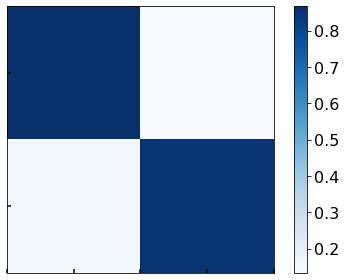

In [467]:
# Define classifiers
conversion_indices = {
  'aC': 0,
  'G': 1,
}

# Plot confusion matrix
confusion_matrix = np.zeros((len(conversion_indices), len(conversion_indices)))

for i in range(len(y_true)):
    confusion_matrix[int(y_true[i]), int(y_pred[i])] += 1
    
print("\n===== Confusion Matrix (between subject's) =====")
print(confusion_matrix)

for i in range(confusion_matrix.shape[0]):
    # print(sum(confusion_matrix[i, :]))
    confusion_matrix[i, :] = confusion_matrix[i, :]/sum(confusion_matrix[i, :])
    
print("\n===== Normalized Confusion Matrix (between subject's) =====")
print(confusion_matrix)

print("\n===== Colormap of Normalized Confusion Matrix (between subject's) =====")
# Format plot
ax = plt.axes()
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
imshow_kwargs = {
    'cmap': 'Blues',
}
ax.set_yticks([0, 1])
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.imshow(confusion_matrix, **imshow_kwargs)
# plt.xlabel('Predicted', fontname="Arial", fontsize="20", fontweight = "bold")
# plt.ylabel('Actual', fontname="Arial", fontsize="20", fontweight = "bold")
cb = plt.colorbar()
cb.ax.tick_params(labelsize='16')
# plt.show()

metric = classification_report(y_true, y_pred)
print(metric)

# Format and save
plt.tight_layout()
# plt.savefig('ConfusionMatrixClassifier.png', dpi=300) # Change file name
# plt.show(

/Users/jacobbeckham/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jacobbeckham/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.944
Logistic: ROC AUC=0.888
Logistic: ROC AUC=0.789
Logistic: ROC AUC=0.875
Logistic: ROC AUC=0.898
Logistic: ROC AUC=0.836


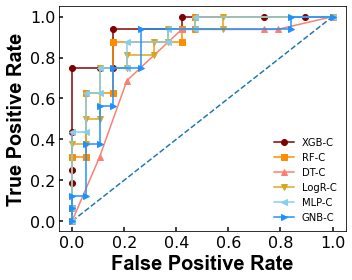

In [490]:

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# Affix variables
testy=test_labels
testX = test_features
trainX = train_features
trainy = train_labels

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
# model = RandomForestClassifier(max_depth=4, n_estimators=200)

# Instantiate Models
model1 = XGBClassifier(max_depth=5, min_child_weight = 5, n_estimators = 40, learning_rate = 0.08, gamma=0.1, subsample=0.75)
model1.fit(trainX, trainy)

model2 = RandomForestClassifier(max_depth=5, min_samples_split=2)
model2.fit(trainX, trainy)

model3 = DecisionTreeClassifier(max_depth=3, min_samples_split=2)
model3.fit(trainX, trainy)

model4 = LogisticRegression(solver='lbfgs')
model4.fit(trainX, trainy)

model5 = MLPClassifier(hidden_layer_sizes=(200, 200, 200), activation='logistic', 
                   alpha=0.05, learning_rate = 'constant', solver='adam')
model5.fit(trainX, trainy)

# model6 = RidgeClassifier()
# model6.fit(trainX, trainy)

model6 = GaussianNB()
model6.fit(trainX, trainy)

# Start here tomorrow, go through and copy the hyperparameters from below. Don't count on being able to find the same ones. 
###
###
###

# predict probabilities
lr_probs1 = model1.predict_proba(testX)
lr_probs2 = model2.predict_proba(testX)
lr_probs3 = model3.predict_proba(testX)
lr_probs4 = model4.predict_proba(testX)
lr_probs5 = model5.predict_proba(testX)
lr_probs6 = model6.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs1 = lr_probs1[:, 1]
lr_probs2 = lr_probs2[:, 1]
lr_probs3 = lr_probs3[:, 1]
lr_probs4 = lr_probs4[:, 1]
lr_probs5 = lr_probs5[:, 1]
lr_probs6 = lr_probs6[:, 1]

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc1 = roc_auc_score(testy, lr_probs1)
lr_auc2 = roc_auc_score(testy, lr_probs2)
lr_auc3 = roc_auc_score(testy, lr_probs3)
lr_auc4 = roc_auc_score(testy, lr_probs4)
lr_auc5 = roc_auc_score(testy, lr_probs5)
lr_auc6 = roc_auc_score(testy, lr_probs6)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc1))
print('Logistic: ROC AUC=%.3f' % (lr_auc2))
print('Logistic: ROC AUC=%.3f' % (lr_auc3))
print('Logistic: ROC AUC=%.3f' % (lr_auc4))
print('Logistic: ROC AUC=%.3f' % (lr_auc5))
print('Logistic: ROC AUC=%.3f' % (lr_auc6))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr1, lr_tpr1, _ = roc_curve(testy, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(testy, lr_probs2)
lr_fpr3, lr_tpr3, _ = roc_curve(testy, lr_probs3)
lr_fpr4, lr_tpr4, _ = roc_curve(testy, lr_probs4)
lr_fpr5, lr_tpr5, _ = roc_curve(testy, lr_probs5)
lr_fpr6, lr_tpr6, _ = roc_curve(testy, lr_probs6)

fig, ax = plt.subplots(figsize=(5,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr1, lr_tpr1, marker='o', label='XGB-C', color='maroon')
pyplot.plot(lr_fpr2, lr_tpr2, marker='s', label='RF-C', color='darkorange')
pyplot.plot(lr_fpr3, lr_tpr3, marker='^', label='DT-C', color='salmon')
pyplot.plot(lr_fpr4, lr_tpr4, marker='v', label='LogR-C', color='goldenrod')
pyplot.plot(lr_fpr5, lr_tpr5, marker='<', label='MLP-C', color='skyblue')
pyplot.plot(lr_fpr6, lr_tpr6, marker='>', label='GNB-C', color='dodgerblue')

# axis labels
pyplot.xlabel('False Positive Rate', fontname="Arial", fontsize="20", fontweight = "bold")
pyplot.ylabel('True Positive Rate', fontname="Arial", fontsize="20", fontweight = "bold")
# show the legend
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=1)
# show the plot
# Format and save
plt.tight_layout()
# plt.savefig('ROCcurves.png', dpi=300) # Change file name
plt.show()

In [349]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: charge_density       Importance: 0.41999998688697815
Variable: Norm_charge_tot      Importance: 0.17000000178813934
Variable: Material_MC          Importance: 0.1599999964237213
Variable: Final_Current_Percent Importance: 0.11999999731779099
Variable: Norm_I_Max           Importance: 0.10000000149011612
Variable: Material_CB          Importance: 0.019999999552965164


In [297]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (45,50,51,52),
            'min_child_weight': range(2,5),
            'learning_rate': np.linspace(0.07, 0.13, 6),
            'subsample': np.linspace(0.7, 0.8, 5),
            'gamma': np.linspace(0.07, 0.13, 6)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('Max Depth: ', best_params["max_depth"])
print('N Estimators: ', best_params["n_estimators"])
print('Min Child Weight: ', best_params["min_child_weight"])
print('Learning Rate: ', best_params["learning_rate"])
print('Subsample: ', best_params["subsample"])
print('Gamma: ', best_params["gamma"])

Max Depth:  4
N Estimators:  52
Min Child Weight:  2
Learning Rate:  0.11800000000000001
Subsample:  0.75
Gamma:  0.082


In [460]:
# Train neural network
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator=MLPClassifier(),
        param_grid={'hidden_layer_sizes': [(100, 100, 100), (10,10,10), (50,50,50), (200, 200, 200)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.05, 0.10, 0.12, 0.15],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam'],
          'n_iter_no_change': range(3,7)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('hidden layer: ', best_params["hidden_layer_sizes"])
print('activation: ', best_params["activation"])
print('learning_rate: ', best_params["learning_rate"])
print('solver ', best_params["solver"])
print('alpha ', best_params["alpha"])

hidden layer:  (200, 200, 200)
activation:  logistic
learning_rate:  constant
solver  adam
alpha  0.05


In [440]:
# Decision tree
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'max_depth': range(3,7), 
            'min_samples_split': range(2,4)
            # 'learning_rate': (0.0001, 0.001, 0.01, 0.1, 0.2), 
            # 'n_estimators': (100, 200, 300, 400, 500)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('Max depth: ', best_params["max_depth"])
print('Min samples split: ', best_params["min_samples_split"])

Max depth:  3
Min samples split:  2


In [445]:
# Decision tree
gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'max_depth': range(3,7), 
            'min_samples_split': range(2,4)
            # 'learning_rate': (0.0001, 0.001, 0.01, 0.1, 0.2), 
            # 'n_estimators': (100, 200, 300, 400, 500)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('Max depth: ', best_params["max_depth"])
print('Min samples split: ', best_params["min_samples_split"])

Max depth:  5
Min samples split:  2
